<a href="https://colab.research.google.com/github/leonpalafox/CodigoLeon/blob/master/StringMatchingExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ruptures

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.8 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed
Close Change-point 1: Mean = -0.0025, Std Dev = 0.0047
Close Change-point 2: Mean = 0.0188, Std Dev = 0.0094
Close Change-point 3: Mean = -0.0022, Std Dev = 0.0052
Close Change-point 4: Mean = 0.0080, Std Dev = 0.0087
Close Change-point 5: Mean = -0.0055, Std Dev = 0.0101
Close Change-point 6: Mean = 0.0192, Std Dev = 0.0059


<ipython-input-29-dd74baac15a5>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10").colors


Volume Change-point 1: Mean = 0.0780, Std Dev = 0.1055


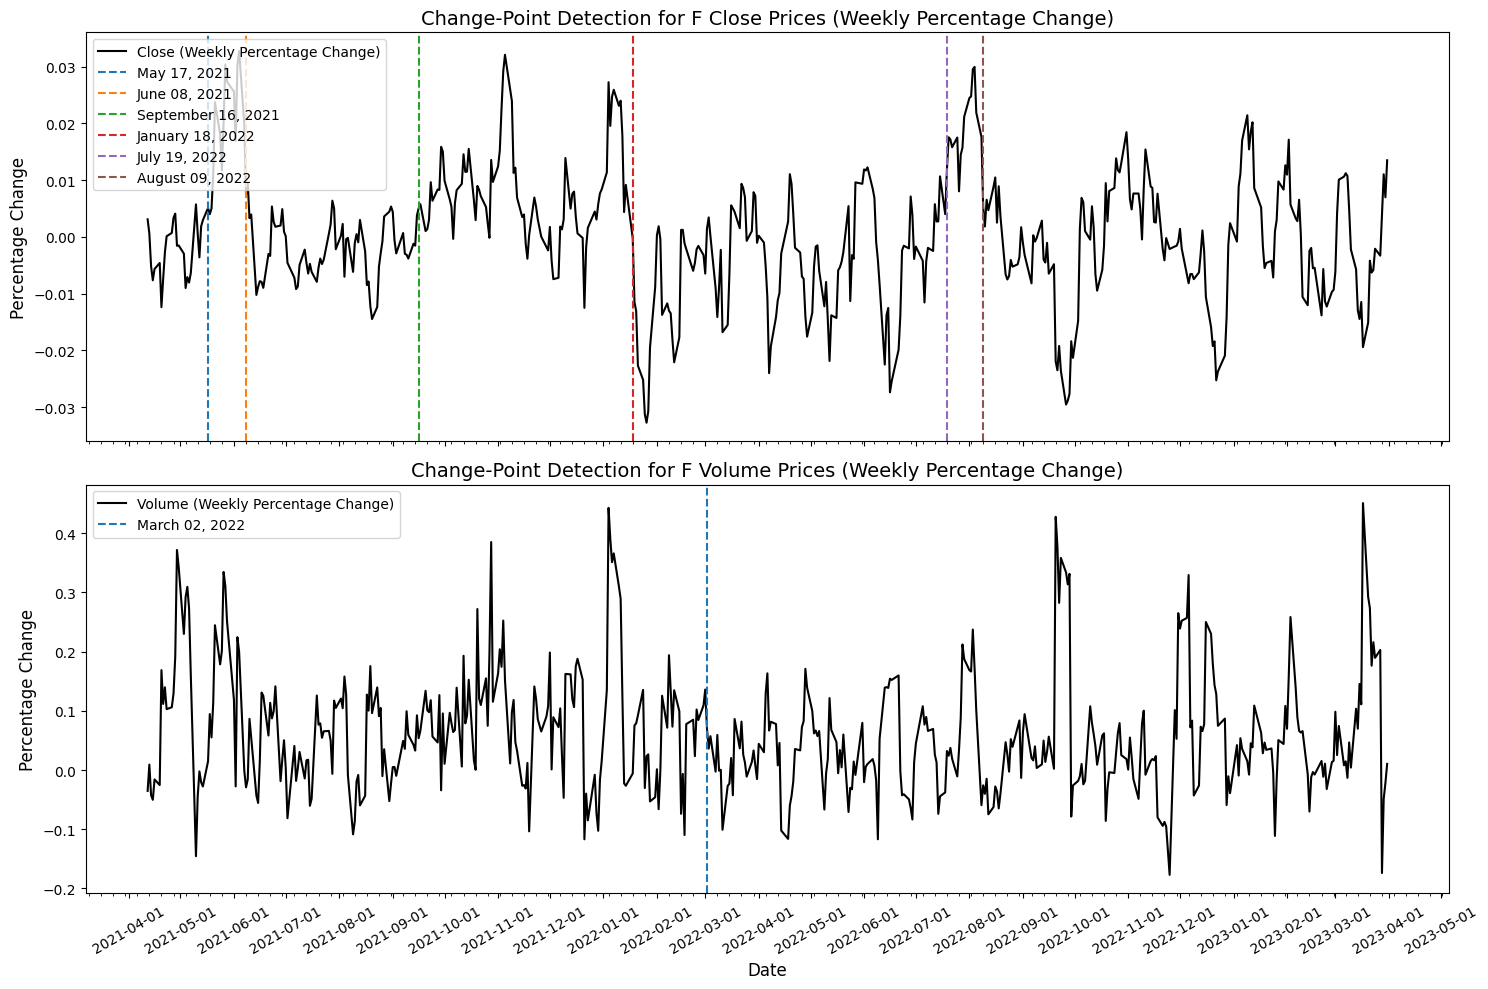

In [29]:
import yfinance as yf
import pandas as pd
import ruptures as rpt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Define the ticker symbol, start date, and end date for the stock data to be analyzed
ticker = "F" # Example: "AAPL", "GOOG", "TSLA"
start_date = "2021-04-01" # Example: "2019-01-01", "2020-06-01"
end_date = "2023-04-01" # Example: "2022-12-31", "2023-05-31"

# Download stock data for the given ticker symbol and date range
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Define the features to be analyzed (can be any feature available in the stock data)
features = ['Close', 'Volume'] # Example: ['Open', 'Close'], ['High', 'Low', 'Close']

# Set up a color palette for the change-points
colors = plt.cm.get_cmap("tab10").colors

# Loop over each feature and perform change-point detection analysis
fig, axs = plt.subplots(len(features), 1, figsize=(15, 10), sharex=True)
for i, feat in enumerate(features):
    # Compute the percentage change in stock prices and smooth the data on a weekly basis
    pct_change = stock_data[feat].pct_change() # Calculate percentage change in stock prices
    pct_change_weekly = pct_change.rolling(window=7, min_periods=1).mean() # Smooth on a weekly basis
    pct_change_weekly = pct_change_weekly.values[6:] # Remove first 6 NaN values
    dates_weekly = stock_data.index[6:] # Corresponding weekly dates

    # Fit the Pelt change-point detection model with adjusted parameters
    model = "rbf" # Example: "l2", "linear"
    pen = 5 # Penalty value for change-points (higher values lead to fewer change-points)
    min_size = 2 # Minimum size of a segment (smaller values lead to more change-points)
    jump = 5 # Minimum distance between change-points (higher values lead to fewer change-points)
    algo = rpt.Pelt(model=model, jump=jump, min_size=min_size).fit(pct_change_weekly)

    # Identify the change-point locations
    cps = algo.predict(pen=pen)

    # Plot the results
    axs[i].plot(dates_weekly, pct_change_weekly, 'k-', label=f"{feat} (Weekly Percentage Change)", lw=1.5)
    for j, cp in enumerate(cps[:-1]):
        if j == 0:
            start = 0
        else:
            start = cps[j - 1]
        end = cp
        mean = pct_change_weekly[start:end].mean()
        std = pct_change_weekly[start:end].std()
        cp_date = dates_weekly[cp].strftime('%B %d, %Y') # Format change-point date
        axs[i].axvline(x=dates_weekly[cp], color=colors[j % len(colors)], linestyle='--', label=f"{cp_date}")
        print(f"{feat} Change-point {j+1}: Mean = {mean:.4f}, Std Dev = {std:.4f}") # Print change-point statistics

    axs[i].set_title(f"Change-Point Detection for {ticker} {feat} Prices (Weekly Percentage Change)", fontsize=14)
    axs[i].set_ylabel("Percentage Change", fontsize=12)
    axs[i].legend(loc='upper left', fontsize=10)

    # Improve x-axis ticks and labels
    axs[i].xaxis.set_major_locator(mdates.MonthLocator()) # Major ticks at the beginning of each month
    axs[i].xaxis.set_minor_locator(mdates.WeekdayLocator()) # Minor ticks at each weekday

# Format x-axis date labels
axs[-1].set_xlabel("Date", fontsize=12)
axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # Format major ticks as "YYYY-MM-DD"
axs[-1].tick_params(axis='x', labelrotation=30) # Rotate x-axis tick labels by 30 degrees for better readability

plt.tight_layout()
plt.show()



[*********************100%***********************]  1 of 1 completed


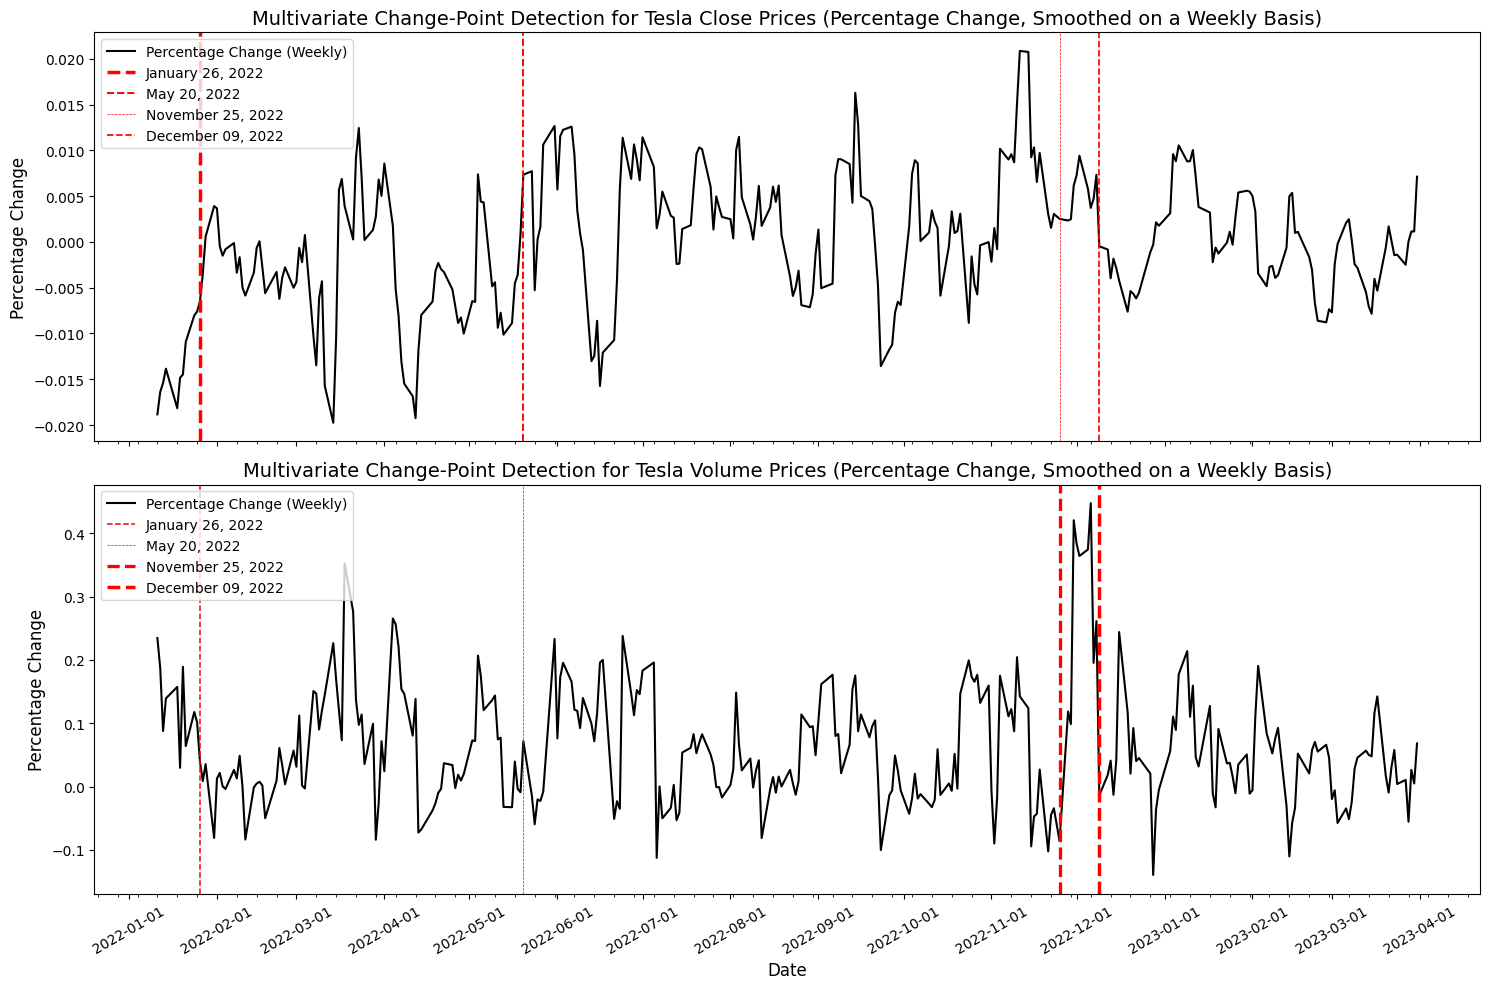

In [26]:
import yfinance as yf
import pandas as pd
import ruptures as rpt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Download stock data for Tesla
ticker = "SBUX"
start_date = "2022-01-01"
end_date = "2023-04-01"
tesla_data = yf.download(ticker, start=start_date, end=end_date)

# Define list of features to analyze
features = ['Close', 'Volume']

# Compute percentage change in stock price and volume and smooth on a weekly basis
ts_close = tesla_data['Close'].pct_change()
ts_volume = tesla_data['Volume'].pct_change()
ts_close_weekly = ts_close.rolling(window=7, min_periods=1).mean()
ts_volume_weekly = ts_volume.rolling(window=7, min_periods=1).mean()

# Combine the percentage change data into a single 2D array
ts_combined = np.column_stack((ts_close_weekly.values[6:], ts_volume_weekly.values[6:]))
dates_weekly = tesla_data.index[6:]

# Fit the Pelt change-point detection model using Mahalanobis distance
model = "mahalanobis"
pen = 20
min_size = 2
jump = 5
algo = rpt.Pelt(model=model, jump=jump, min_size=min_size).fit(ts_combined)

# Identify change-point locations
cps = algo.predict(pen=pen)

# Function to calculate the normalized absolute difference between two segments
def calculate_thickness(ts_weekly, cps):
    thickness_values = []
    for j in range(len(cps) - 1):
        start = cps[j - 1] if j > 0 else 0
        end = cps[j]
        next_end = cps[j + 1]
        mean1 = ts_weekly[start:end].mean()
        mean2 = ts_weekly[end:next_end].mean()
        thickness_values.append(abs(mean1 - mean2))
    thickness_values = np.array(thickness_values)
    return (thickness_values - thickness_values.min()) / (thickness_values.max() - thickness_values.min())

# Plot the results
fig, axs = plt.subplots(len(features), 1, figsize=(15, 10), sharex=True)
for i, feat in enumerate(features):
    if feat == 'Close':
        ts_weekly = ts_close_weekly[6:]
    else:
        ts_weekly = ts_volume_weekly[6:]

    axs[i].plot(dates_weekly, ts_weekly, 'k-', label="Percentage Change (Weekly)", lw=1.5)
    
    thickness_values = calculate_thickness(ts_weekly, cps)
    
    for j, cp in enumerate(cps[:-1]):
        cp_date = dates_weekly[cp].strftime('%B %d, %Y')
        linewidth = 0.5 + 2 * thickness_values[j]
        axs[i].axvline(x=dates_weekly[cp], color='r', linestyle='--', label=f"{cp_date}", lw=linewidth)
        axs[i].legend(loc='upper left', fontsize=10)

    axs[i].set_title(f"Multivariate Change-Point Detection for Tesla {feat} Prices (Percentage Change, Smoothed on a Weekly Basis)", fontsize=14)
    axs[i].set_ylabel("Percentage Change", fontsize=12)

    # Improve x-axis ticks and labels
    axs[i].xaxis.set_major_locator(mdates.MonthLocator())
    axs[i].xaxis.set_minor_locator(mdates.WeekdayLocator())

# Format x-axis date labels
axs[-1].set_xlabel("Date", fontsize=12)
axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axs[-1].tick_params(axis='x', labelrotation=30)

plt.tight_layout()
plt.show()




In [28]:
cps

[10, 90, 220, 230, 307]